# Full ANN classification example using EMVIC_3C dataset

In [1]:
import pandas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from collections import Counter

### Load data

In [22]:
dataframe = pandas.read_csv("emvic_3c.csv")
dataset = dataframe.values
samples = dataset[:,1:]
labels = dataset[:,0]
samples = np.array(samples)
labels = np.array(labels)
labels = labels.astype(str)

print("Class distribution:")
print(Counter(labels))

Class distribution:
Counter({'a25': 105, 'a41': 39, 'a37': 11})


### Choose k best attributes

In [23]:
from sklearn.feature_selection import SelectKBest
newSamples = SelectKBest(k=100).fit_transform(samples, labels)
print(newSamples.shape) 
samples = newSamples

(155, 100)


C:\programs\miniconda3\envs\deep\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [    0     1     2     3     4     5     6     7 16376 16377 16378 16379
 16380 16381 16382 16383] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\programs\miniconda3\envs\deep\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Calculate weights for unbalanced classes

In [24]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(labels),y=labels)
d_class_weights = dict(enumerate(class_weights))
print("Class weights:",d_class_weights)

Class weights: {0: 0.49206349206349204, 1: 4.696969696969697, 2: 1.3247863247863247}


### Normalize samples

In [25]:
from sklearn.preprocessing import normalize
print(samples[0,:10])
samples = normalize(samples)
print(samples[0,:10])

[24.02 13.93 12.0 5.39 -780.0 -778.0 -779.0 -776.0 -773.0 -774.0]
[ 0.00424979  0.0024646   0.00212313  0.00095364 -0.13800332 -0.13764946
 -0.13782639 -0.13729561 -0.13676483 -0.13694175]


### Convert to one-hot encoding

In [26]:
print("Shape before",labels.shape)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Shape after",labels.shape)
classesNum = labels.shape[1]
print ("Classes: {}".format(classesNum))

Shape before (155,)
Shape after (155, 3)
Classes: 3


### Division into training and test samples

In [27]:
from sklearn.model_selection._split import train_test_split
(trainSamples, testSamples, trainLabels, testLabels) = train_test_split(samples, labels, test_size=0.25, random_state=42)
print('Train samples',len(trainSamples))
print('Test samples',len(testSamples))


Train samples 116
Test samples 39


### Create the model

In [28]:
model = Sequential()
model.add(Dense(250, activation='sigmoid',input_dim=100))
model.add(Dense(250, activation='sigmoid'))
model.add(Dense(250, activation='sigmoid'))
model.add(Dense(classesNum, activation='softmax'))

## loss function depends on the number of classes!
loss='categorical_crossentropy'    
model.compile(loss=loss, optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 250)               25250     
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_6 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 753       
Total params: 151,503
Trainable params: 151,503
Non-trainable params: 0
_________________________________________________________________


### Fit and validate the model

In [29]:
EPOCHS=100
BATCH=50
H = model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS
              ,class_weight=d_class_weights
              ,validation_data=(testSamples,testLabels)
              #,validation_split=0.1
              )
mlpResults = model.predict(testSamples)

Epoch 1/100
3/3 [==============================] - 0s 45ms/step - loss: 1.3282 - accuracy: 0.5690 - val_loss: 1.5098 - val_accuracy: 0.0256
Epoch 2/100
3/3 [==============================] - 0s 7ms/step - loss: 1.2430 - accuracy: 0.0862 - val_loss: 1.3552 - val_accuracy: 0.0256
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 1.1634 - accuracy: 0.0862 - val_loss: 1.1184 - val_accuracy: 0.0256
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: 1.2042 - accuracy: 0.1638 - val_loss: 1.0184 - val_accuracy: 0.2821
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 1.1815 - accuracy: 0.2069 - val_loss: 1.1831 - val_accuracy: 0.0256
Epoch 6/100
3/3 [==============================] - 0s 7ms/step - loss: 1.1378 - accuracy: 0.0862 - val_loss: 1.2408 - val_accuracy: 0.0256
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: 1.1436 - accuracy: 0.0862 - val_loss: 1.2035 - val_accuracy: 0.0256
Epoch 8/100
3/3 [=========

### Print results

In [30]:
print(confusion_matrix(testLabels.argmax(axis=1), mlpResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), mlpResults.argmax(axis=1),target_names=lb.classes_))
mlpAcc = accuracy_score(testLabels.argmax(axis=1), mlpResults.argmax(axis=1)) 
print("MLP Accuracy: {:.2f}".format(mlpAcc))

[[22  2  3]
 [ 0  1  0]
 [ 0  4  7]]
              precision    recall  f1-score   support

         a25       1.00      0.81      0.90        27
         a37       0.14      1.00      0.25         1
         a41       0.70      0.64      0.67        11

    accuracy                           0.77        39
   macro avg       0.61      0.82      0.60        39
weighted avg       0.89      0.77      0.82        39

MLP Accuracy: 0.77


In [11]:
H.history

{'loss': [1.14834463596344,
  1.1277714967727661,
  1.1106094121932983,
  1.094785213470459,
  1.082821011543274,
  1.1044971942901611,
  1.097408652305603,
  1.0561436414718628,
  1.0718848705291748,
  1.1064207553863525,
  1.0620516538619995,
  1.0261385440826416,
  1.0571751594543457,
  1.0114331245422363,
  0.9615175724029541,
  1.0215295553207397,
  0.9591893553733826,
  0.8805890083312988,
  0.829841673374176,
  0.7893301844596863,
  0.7487465739250183,
  0.726216733455658,
  0.7240620255470276,
  0.7018238306045532,
  0.6852338910102844,
  0.681088924407959,
  0.6876192092895508,
  0.6726878881454468,
  0.6912573575973511,
  0.7247921228408813,
  0.693088173866272,
  0.6630750298500061,
  0.6911140084266663,
  0.7240628600120544,
  0.7050644159317017,
  0.6843645572662354,
  0.6650519371032715,
  0.671751856803894,
  0.6686380505561829,
  0.6727421879768372,
  0.6607136726379395,
  0.6610344052314758,
  0.6696494221687317,
  0.6714414954185486,
  0.6636785268783569,
  0.66294622

### Show history

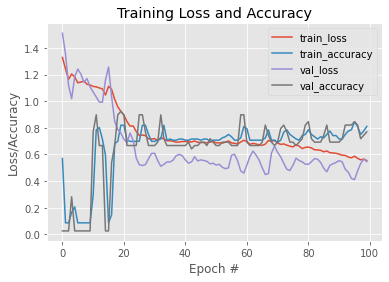

In [31]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
    
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Decision Tree model for comparison

In [13]:
from sklearn.tree import DecisionTreeClassifier
treemodel = DecisionTreeClassifier()
treemodel.fit(trainSamples, trainLabels)
treeResults = treemodel.predict(testSamples)    
print(confusion_matrix(testLabels.argmax(axis=1), treeResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), treeResults.argmax(axis=1)))
treeAcc = accuracy_score(testLabels.argmax(axis=1), treeResults.argmax(axis=1)) 
print("Tree Accuracy: {:.2f}".format(treeAcc))

[[25  0  1]
 [ 1  0  2]
 [ 0  2  8]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.00      0.00      0.00         3
           2       0.73      0.80      0.76        10

    accuracy                           0.85        39
   macro avg       0.56      0.59      0.57        39
weighted avg       0.83      0.85      0.84        39

Tree Accuracy: 0.85


### kNN for comparison

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier()
knnmodel.fit(trainSamples, trainLabels)
knnResults = knnmodel.predict(testSamples)    
print(confusion_matrix(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
knnAcc = accuracy_score(testLabels.argmax(axis=1), knnResults.argmax(axis=1)) 
print("kNN Accuracy: {:.2f}".format(knnAcc))

[[25  0  1]
 [ 1  0  2]
 [ 3  0  7]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       0.00      0.00      0.00         3
           2       0.70      0.70      0.70        10

    accuracy                           0.82        39
   macro avg       0.52      0.55      0.54        39
weighted avg       0.75      0.82      0.79        39

kNN Accuracy: 0.82


C:\programs\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
